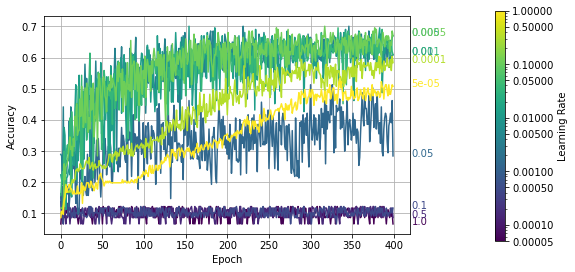

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib as mpl

# Load data
data_path = 'NEW_RESULTS/16_Accuracies_results.adam.pt'
Accuracies_lr = torch.load(data_path)  
LearningRate = [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]

# Viridis colormap
cmap = plt.get_cmap('viridis') 

# Plot colors
colors = cmap(np.linspace(0, 1, Accuracies_lr.shape[0]))
colors = colors.tolist()

# Plot  
fig, ax = plt.subplots(figsize=(7,4))

for i in range(Accuracies_lr.shape[0]):
    ax.plot(range(Accuracies_lr.shape[1]), Accuracies_lr[i], color=colors[i])
    
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.grid()

# Legend
for i in range(Accuracies_lr.shape[0]):
    ax.annotate(str(LearningRate[i]), xy=(1.0, Accuracies_lr[i, -1]),
                xycoords='data', xytext=(350, 0), textcoords='offset points', 
                color=colors[i])
      
# Learning rate colorbar
cmap_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])
# Get min and max learning rates
lr_min = min(LearningRate) 
lr_max = max(LearningRate)
norm = mpl.colors.LogNorm(vmin=lr_min, vmax=lr_max) 
cb = mpl.colorbar.ColorbarBase(cmap_ax, cmap=cmap,norm=norm, orientation='vertical')
cb.set_label('Learning Rate')

# Update colorbar ticks

# Set dynamic ticks
cb.set_ticks(LearningRate)

# Format tick labels 
cb.set_ticklabels(["{:.5f}".format(lr) for lr in LearningRate])

# Layout  
fig.subplots_adjust(right=0.85)

plt.show()

In [2]:
import os
import random
import torch
import numpy as np
import soundfile as sf
from torch.utils import data
from torchaudio_augmentations import (
    RandomResizedCrop,
    RandomApply,
    PolarityInversion,
    Noise,
    Gain,
    HighLowPass,
    Delay,
    PitchShift,
    Reverb,
    Compose,
)


GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


class GTZANDataset(data.Dataset):
    def __init__(self, data_path, split, num_samples, num_chunks, is_augmentation):
        self.data_path =  data_path if data_path else ''
        self.split = split
        self.num_samples = num_samples
        self.num_chunks = num_chunks
        self.is_augmentation = is_augmentation
        self.genres = GTZAN_GENRES
        self._get_song_list()
        if is_augmentation:
            self._get_augmentations()

    def _get_song_list(self):
        list_filename = os.path.join(self.data_path, '%s_filtered.txt' % self.split)
        with open(list_filename) as f:
            lines = f.readlines()
        self.song_list = [line.strip() for line in lines]

    def _get_augmentations(self):
        transforms = [
            RandomResizedCrop(n_samples=self.num_samples),
            RandomApply([PolarityInversion()], p=0.8),
            RandomApply([Noise(min_snr=0.3, max_snr=0.5)], p=0.3),
            RandomApply([Gain()], p=0.2),
            RandomApply([HighLowPass(sample_rate=22050)], p=0.8),
            RandomApply([Delay(sample_rate=22050)], p=0.5),
            RandomApply([PitchShift(n_samples=self.num_samples, sample_rate=22050)], p=0.4),
            RandomApply([Reverb(sample_rate=22050)], p=0.3),
        ]
        self.augmentation = Compose(transforms=transforms)

    def _adjust_audio_length(self, wav):
        if self.split == 'train':
            random_index = random.randint(0, len(wav) - self.num_samples - 1)
            wav = wav[random_index : random_index + self.num_samples]
        else:
            hop = (len(wav) - self.num_samples) // self.num_chunks
            wav = np.array([wav[i * hop : i * hop + self.num_samples] for i in range(self.num_chunks)])
        return wav

    def __getitem__(self, index):
        line = self.song_list[index]

        # get genre
        genre_name = line.split('/')[0]
        genre_index = self.genres.index(genre_name)

        # get audio
        audio_filename = os.path.join(self.data_path, 'genres', line)
        wav, fs = sf.read(audio_filename)

        # adjust audio length
        wav = self._adjust_audio_length(wav).astype('float32')

        # data augmentation
        if self.is_augmentation:
            wav = self.augmentation(torch.from_numpy(wav).unsqueeze(0)).squeeze(0).numpy()

        return wav, genre_index

    def __len__(self):
        return len(self.song_list)

def get_dataloader(data_path=None, 
                   split='train', 
                   num_samples=22050 * 29, 
                   num_chunks=1, 
                   batch_size=16, 
                   num_workers=0, 
                   is_augmentation=False):
    is_shuffle = True if (split == 'train') else False
    batch_size = batch_size if (split == 'train') else (batch_size // num_chunks)
    data_loader = data.DataLoader(dataset=GTZANDataset(data_path, 
                                                       split, 
                                                       num_samples, 
                                                       num_chunks, 
                                                       is_augmentation),
                                  batch_size=batch_size,
                                  shuffle=is_shuffle,
                                  drop_last=False,
                                  num_workers=num_workers)
    return data_loader

curr_batchsize=16

from torch import nn
import torchaudio

class Conv_2d(nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, pooling=2, dropout=0.1):
        super(Conv_2d, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, shape, padding=shape//2)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(pooling)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, wav):
        out = self.conv(wav)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out


class CNN(nn.Module):
    def __init__(self, num_channels=16, 
                       sample_rate=22050, 
                       n_fft=1024, 
                       f_min=0.0, 
                       f_max=11025.0, 
                       num_mels=128, 
                       num_classes=10):
        super(CNN, self).__init__()

        # mel spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, 
                                                            n_fft=n_fft, 
                                                            f_min=f_min, 
                                                            f_max=f_max, 
                                                            n_mels=num_mels)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
        self.input_bn = nn.BatchNorm2d(1)

        # convolutional layers
        self.layer1 = Conv_2d(1, num_channels, pooling=(2, 3))
        self.layer2 = Conv_2d(num_channels, num_channels, pooling=(3, 4))
        self.layer3 = Conv_2d(num_channels, num_channels * 2, pooling=(2, 5))
        self.layer4 = Conv_2d(num_channels * 2, num_channels * 2, pooling=(3, 3))
        self.layer5 = Conv_2d(num_channels * 2, num_channels * 4, pooling=(3, 4))

        # dense layers
        self.dense1 = nn.Linear(num_channels * 4, num_channels * 4)
        self.dense_bn = nn.BatchNorm1d(num_channels * 4)
        self.dense2 = nn.Linear(num_channels * 4, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, wav):
        # input Preprocessing
        out = self.melspec(wav)
        out = self.amplitude_to_db(out)

        # input batch normalization
        out = out.unsqueeze(1)
        out = self.input_bn(out)

        # convolutional layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        
        # reshape. (batch_size, num_channels, 1, 1) -> (batch_size, num_channels)
        out = out.reshape(len(out), -1)

        # dense layers
        out = self.dense1(out)
        out = self.dense_bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.dense2(out)

        return out
device = torch.device('cpu')
cnn = CNN().to(device)


In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix
import random

# Load the best model
S = torch.load('16/16_best_model_sgd.ckpt')
cnn.load_state_dict(S)
print('loaded!')

# Run evaluation
cnn.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for wav, genre_index in test_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # reshape and aggregate chunk-level predictions
        b, c, t = wav.size()
        logits = cnn(wav.view(-1, t))
        logits = logits.view(b, c, -1).mean(dim=1)
        _, pred = torch.max(logits.data, 1)

        # append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())

import seaborn as sns
from sklearn.metrics import confusion_matrix

accuracylist=[]



accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
print('Accuracy: %.4f' % accuracy)
accuracylist.append(accuracy)

loaded!


NameError: name 'test_loader' is not defined

Randomness: 0.1172


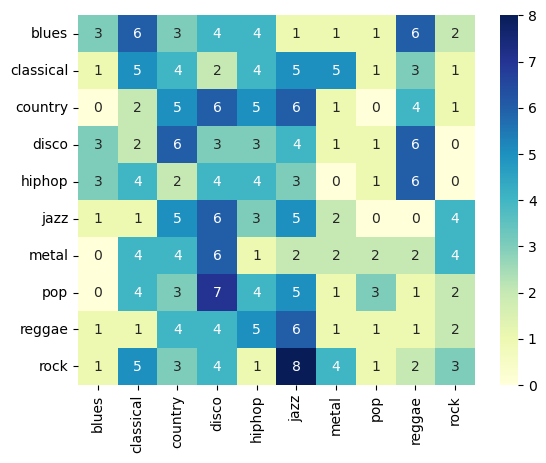

In [26]:
from random import shuffle
shuffle(y_true)
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
print('Randomness: %.4f' % accuracy)